In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib


In [2]:
import feature_extractor as fe
import data_cleaner as dc
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import pandas as pd
# import numpy as np
# sys.path.append('../..')
# import omama as O

In [3]:
# cache_path = "/home/ryan.zurrin001/binlink/sample_dataset.pkl"
cache_path = "/home/ryan.zurrin001/binlink/cs438_features_imgs.pkl"

In [4]:
# Load the DataFrame
df_features = pd.read_pickle(cache_path)

In [5]:
len(df_features)

163568

In [6]:
len(df_features.columns)

36

In [7]:
df_features.columns

Index(['path', 'label', 'StudyInstanceUID', 'ImageLaterality',
       'SOPInstanceUID', 'PatientAge', 'Manufacturer', 'ManufacturerModelName',
       'DistanceSourceToDetector', 'DistanceSourceToPatient', 'ExposureTime',
       'XRayTubeCurrent', 'Exposure', 'ExposureInuAs', 'KVP',
       'BodyPartThickness', 'CompressionForce', 'PositionerPrimaryAngle',
       'ViewPosition', 'DetectorTemperature', 'DetectorType',
       'FieldOfViewOrigin', 'Rows', 'Columns', 'PixelSpacing',
       'BreastImplantPresent', 'WindowCenter', 'WindowWidth', 'HalfValueLayer',
       'original_shape', 'shape', 'coords', 'resized_coords', 'score',
       'histogram', 'image'],
      dtype='object')

In [9]:
column_names = df_features.columns.tolist()

In [12]:
# Convert unhashable types (like lists) to hashable types (like tuples)
for col in df_features.columns:
    if isinstance(df_features[col].iloc[0], (list, dict)):  # Check if the first element is a list or a dictionary
        df_features[col] = df_features[col].apply(tuple)  # Convert lists to tuples


In [14]:
for col in df_features.columns:
    try:
        unique_count = df_features[col].nunique()
        print(f"Column '{col}' has {unique_count} unique values")
    except TypeError as e:
        print(f"Column '{col}' is causing a TypeError: {e}")


Column 'path' has 163568 unique values
Column 'label' has 4 unique values
Column 'StudyInstanceUID' has 157814 unique values
Column 'ImageLaterality' has 2 unique values
Column 'SOPInstanceUID' has 163568 unique values
Column 'PatientAge' has 776 unique values
Column 'Manufacturer' has 6 unique values
Column 'ManufacturerModelName' has 29 unique values
Column 'DistanceSourceToDetector' has 2 unique values
Column 'DistanceSourceToPatient' has 79 unique values
Column 'ExposureTime' has 2489 unique values
Column 'XRayTubeCurrent' has 46 unique values
Column 'Exposure' has 281 unique values
Column 'ExposureInuAs' has 2320 unique values
Column 'KVP' has 21 unique values
Column 'BodyPartThickness' has 119 unique values
Column 'CompressionForce' has 566 unique values
Column 'PositionerPrimaryAngle' has 291 unique values
Column 'ViewPosition' has 4 unique values
Column 'DetectorTemperature' has 769 unique values
Column 'DetectorType' has 2 unique values
Column 'FieldOfViewOrigin' is causing a 

In [13]:
# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Feature': df_features.columns,
    'Type': df_features.dtypes.values,
    'Unique Values': [df_features[col].nunique() for col in df_features.columns]
})

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed

# Hide axes
ax.axis('off')

# Create table
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.3]*len(summary_df.columns)
)

# Adjust table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # You can adjust the scale as needed

# Display the table
plt.show()

TypeError: unhashable type: 'MultiValue'

In [28]:
columns_to_display = ['label', 'score', 'ImageLaterality', 'PatientAge', 'Manufacturer', 'ManufacturerModelName', 'ExposureTime','WindowCenter', 'coords']

In [29]:
display(df_features[columns_to_display])

,label,score,ImageLaterality,PatientAge,Manufacturer,ManufacturerModelName,ExposureTime,WindowCenter,coords
0,NonCancer,0.114345,R,476M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_54.20,654,"[2839, 2863, 2809]","(1986.0, 960.0, 2264.0, 1269.0)"
1,NonCancer,0.244264,L,621M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_53.40,962,"[3049, 3079, 3001]","(385.0, 1962.0, 687.0, 2256.0)"
2,Unknown,0.077584,R,876M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_54.20,633,"[2743, 2779, 2695]","(1013.0, 1497.0, 1250.0, 1761.0)"
3,Unknown,0.005008,R,401M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_53.40,638,"[2845, 2863, 2821]","(1334.0, 1676.0, 1674.0, 2011.0)"
4,NonCancer,0.112289,R,532M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_54.20,858,"[3163, 3211, 3085]","(1782.0, 2036.0, 1897.0, 2155.0)"
...,...,...,...,...,...,...,...,...,...
163563,NonCancer,0.463245,L,739M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_53.40,940,"[2785, 2827, 2731]","(572.0, 908.0, 895.0, 1224.0)"
163564,NonCancer,0.201444,L,641M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_53.10.1.1,1243,"[2635, 2701, 2545]","(260.0, 1701.0, 603.0, 1983.0)"
163565,NonCancer,0.122635,R,724M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_53.40,947,"[2131, 2149, 2101]","(1543.0, 596.0, 1752.0, 804.0)"
163566,NonCancer,0.380193,L,382M,GE MEDICAL SYSTEMS,Senographe Essential VERSION ADS_53.40,990,"[2785, 2815, 2743]","(117.0, 1549.0, 348.0, 1762.0)"


In [8]:
cleaner = dc.DataCleaner(df_features)

In [9]:
print("Initial length:", len(cleaner.df))

Initial length: 163568


In [10]:
img_data, cleaned_df = cleaner.clean_data(return_img_mask_data=True, balance_classes=True, scale=True)

Cleaning data...
drop unnecessary columns
handle missing values
process ages
label encode
map labels
handle missing values
add correctness column
balance classes
create binary masks


Processing Data:   0%|          | 0/33064 [00:00<?, ?it/s]

expand and extend columns


Expanding Columns:   0%|          | 0/2 [00:00<?, ?it/s]

Extending Columns:   0%|          | 0/3 [00:00<?, ?it/s]

process and flatten columns
handle missing values
enforce numeric data types
scale data


In [11]:
len(cleaned_df)

33064

In [12]:
cleaned_df.columns

Index(['label', 'ImageLaterality', 'PatientAge', 'Manufacturer',
       'ManufacturerModelName', 'DistanceSourceToDetector',
       'DistanceSourceToPatient', 'ExposureTime', 'XRayTubeCurrent',
       'Exposure', 'ExposureInuAs', 'KVP', 'BodyPartThickness',
       'CompressionForce', 'PositionerPrimaryAngle', 'ViewPosition',
       'DetectorTemperature', 'DetectorType', 'Rows', 'Columns', 'score',
       'target_label', 'coords1', 'coords2', 'coords3', 'coords4',
       'resized_coords1', 'resized_coords2', 'resized_coords3',
       'resized_coords4', 'FieldOfViewOrigin1', 'FieldOfViewOrigin2',
       'WindowCenter1', 'WindowCenter2', 'WindowCenter3', 'WindowCenter4',
       'WindowWidth1', 'WindowWidth2', 'WindowWidth3', 'WindowWidth4',
       'histogram_mean', 'histogram_median', 'histogram_std', 'histogram_min',
       'histogram_max', 'histogram_percentile_25', 'histogram_percentile_50',
       'histogram_percentile_75', 'flattened_image_mean',
       'flattened_image_median', 'fla

In [13]:
len(cleaned_df.columns)

56

In [14]:
columns_to_display = ['label', 'target_label', 'score', 'ImageLaterality', 'PatientAge', 'Manufacturer', 'ManufacturerModelName', 'ExposureTime', 'WindowCenter1', 'WindowCenter2', 'WindowCenter3', 'WindowCenter4',  'coords1', 'coords2', 'coords3', 'coords4']

In [15]:
display(cleaned_df[columns_to_display])

,label,target_label,score,ImageLaterality,PatientAge,Manufacturer,ManufacturerModelName,ExposureTime,WindowCenter1,WindowCenter2,WindowCenter3,WindowCenter4,coords1,coords2,coords3,coords4
0,-0.335826,1,-0.555146,1.003029,-1.019133,-0.260959,0.400808,0.543056,0.119147,0.249665,0.224207,-0.069453,1.089693,-1.372750,0.971151,-1.422187
1,-0.335826,1,0.248554,-0.996980,-0.596168,-0.260959,0.400808,-0.542750,0.017967,0.193974,0.191267,-0.069453,-1.254387,0.233532,-1.338441,0.108905
2,-0.335826,1,-1.348299,1.003029,0.464828,4.106723,-3.352535,-0.480704,-2.288941,-3.474985,-3.466385,-0.069453,0.587816,1.862567,0.856480,2.140080
3,2.977735,0,-0.941656,1.003029,0.156566,-0.260959,0.400808,-0.586182,-0.791474,-0.124258,-0.129892,-0.069453,1.234150,0.779578,0.971151,0.683890
4,2.977735,0,-0.282716,-0.996980,-0.359595,-0.260959,0.963809,0.046687,-0.042741,0.162151,0.207737,-0.069453,-0.959515,0.240358,-0.937093,0.276333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33059,-0.335826,1,-0.794353,1.003029,-0.452790,-0.260959,-0.162194,0.037381,1.576142,0.806573,0.841822,-0.069453,0.909494,-1.033747,0.810905,-1.122578
33060,-0.335826,0,0.499121,1.003029,-0.459959,-0.260959,0.400808,-0.210804,0.726228,0.472428,0.487722,-0.069453,1.138838,-0.683368,0.921166,-0.966164
33061,-0.335826,0,0.917829,1.003029,-0.703702,-0.260959,-0.162194,0.239030,0.382216,0.329223,0.372434,-0.069453,1.545404,-0.469501,1.525394,-0.360337
33062,2.977735,0,-0.650843,-0.996980,0.493504,-0.260959,-0.162194,-0.226315,-0.002269,0.209886,0.158328,-0.069453,-0.684004,0.285862,-0.762146,0.172792


In [14]:
display(cleaned_df[columns_to_display])

,label,target_label,score,ImageLaterality,PatientAge,Manufacturer,ManufacturerModelName,ExposureTime,WindowCenter1,WindowCenter2,WindowCenter3,WindowCenter4,coords1,coords2,coords3,coords4
0,0,1,0.114345,1,39.666667,0,25,654,2839.0,2863.0,2809.0,0.0,1986.0,960.0,2264.0,1269.0
1,0,1,0.244264,0,51.750000,0,22,962,3049.0,3079.0,3001.0,0.0,385.0,1962.0,687.0,2256.0
4,0,1,0.112289,1,44.333333,0,25,858,3163.0,3211.0,3085.0,0.0,1782.0,2036.0,1897.0,2155.0
5,0,1,0.365428,0,75.250000,0,22,1107,2665.0,2713.0,2593.0,0.0,355.0,1127.0,736.0,1456.0
6,0,1,0.064458,1,56.500000,0,19,989,2671.0,2719.0,2611.0,0.0,1297.0,1218.0,1686.0,1534.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163563,0,1,0.463245,0,61.583333,0,22,940,2785.0,2827.0,2731.0,0.0,572.0,908.0,895.0,1224.0
163564,0,1,0.201444,0,53.416667,0,19,1243,2635.0,2701.0,2545.0,0.0,260.0,1701.0,603.0,1983.0
163565,0,1,0.122635,1,60.333333,0,22,947,2131.0,2149.0,2101.0,0.0,1543.0,596.0,1752.0,804.0
163566,0,1,0.380193,0,31.833333,0,22,990,2785.0,2815.0,2743.0,0.0,117.0,1549.0,348.0,1762.0


In [27]:
len(cleaned_df)

161299

In [16]:
cleaned_df

,label,ImageLaterality,PatientAge,Manufacturer,ManufacturerModelName,DistanceSourceToDetector,DistanceSourceToPatient,ExposureTime,XRayTubeCurrent,Exposure,...,histogram_percentile_50,histogram_percentile_75,flattened_image_mean,flattened_image_median,flattened_image_std,flattened_image_min,flattened_image_max,flattened_image_percentile_25,flattened_image_percentile_50,flattened_image_percentile_75
0,0,1,39.666667,0,25,660.0,660.0,654,62,41,...,0.000076,0.000168,58.695709,7.0,82.222314,0,242,6.0,7.0,181.0
1,0,0,51.750000,0,22,660.0,660.0,962,61,60,...,0.000076,0.000290,98.803879,0.0,102.330416,0,246,0.0,0.0,203.0
4,0,1,44.333333,0,25,660.0,660.0,858,62,53,...,0.000107,0.000587,63.388824,14.0,79.600343,0,253,13.0,14.0,178.0
5,0,0,75.250000,0,22,660.0,660.0,1107,62,69,...,0.000076,0.000366,56.863647,0.0,74.328708,0,229,0.0,0.0,149.0
6,0,1,56.500000,0,19,660.0,660.0,989,62,61,...,0.000122,0.001701,84.603943,138.0,76.137374,0,205,5.0,138.0,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163563,0,0,61.583333,0,22,660.0,660.0,940,61,58,...,0.000061,0.000175,56.462296,7.0,73.238716,0,228,6.0,7.0,159.0
163564,0,0,53.416667,0,19,660.0,660.0,1243,60,75,...,0.000122,0.000473,74.738174,0.0,89.472290,0,245,0.0,0.0,177.0
163565,0,1,60.333333,0,22,660.0,660.0,947,62,59,...,0.000107,0.000595,47.728088,5.0,70.445899,0,246,4.0,5.0,144.0
163566,0,0,31.833333,0,22,660.0,660.0,990,61,62,...,0.000061,0.000153,53.578430,2.0,89.580247,0,250,1.0,2.0,79.0


In [28]:
cleaned_df.iloc[4]

label                                    0
ImageLaterality                          1
PatientAge                            56.5
Manufacturer                             0
ManufacturerModelName                   19
DistanceSourceToDetector             660.0
DistanceSourceToPatient              660.0
ExposureTime                           989
XRayTubeCurrent                         62
Exposure                                61
ExposureInuAs                        61400
KVP                                   29.0
BodyPartThickness                     56.0
CompressionForce                      90.0
PositionerPrimaryAngle                54.0
ViewPosition                             1
DetectorTemperature                30.3946
DetectorType                             1
Rows                                  3062
Columns                               2394
score                             0.064458
target_label                             1
coords1                             1297.0
coords2    

In [14]:
len(cleaned_df)

33064

In [15]:
len(img_data)

33064

In [17]:
idx = 6

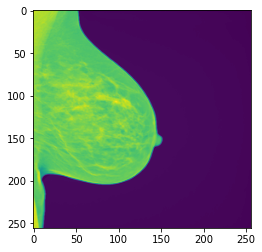

In [18]:
imshow(img_data[idx, :, :, 0] )

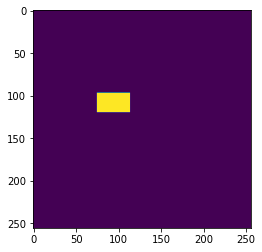

In [19]:
imshow(img_data[idx, :, :, 1] )

              label  ImageLaterality    PatientAge  Manufacturer  \
count  3.306400e+04     3.306400e+04  3.306400e+04  3.306400e+04   
mean   4.212024e-17    -3.610307e-17  1.461315e-16  3.647242e-17   
std    1.000015e+00     1.000015e+00  1.000015e+00  1.000015e+00   
min   -3.358257e-01    -9.969801e-01 -3.327517e+00 -2.609593e-01   
25%   -3.358257e-01    -9.969801e-01 -7.252082e-01 -2.609593e-01   
50%   -3.358257e-01    -9.969801e-01  1.318800e-02 -2.609593e-01   
75%   -3.358257e-01     1.003029e+00  7.014020e-01 -2.609593e-01   
max    2.977735e+00     1.003029e+00  2.335910e+00  6.290565e+00   

       ManufacturerModelName  DistanceSourceToDetector  \
count           3.306400e+04              3.306400e+04   
mean            3.431134e-16             -8.213448e-16   
std             1.000015e+00              1.000015e+00   
min            -3.727869e+00             -7.460244e-02   
25%            -1.621938e-01             -7.460244e-02   
50%             4.008076e-01           

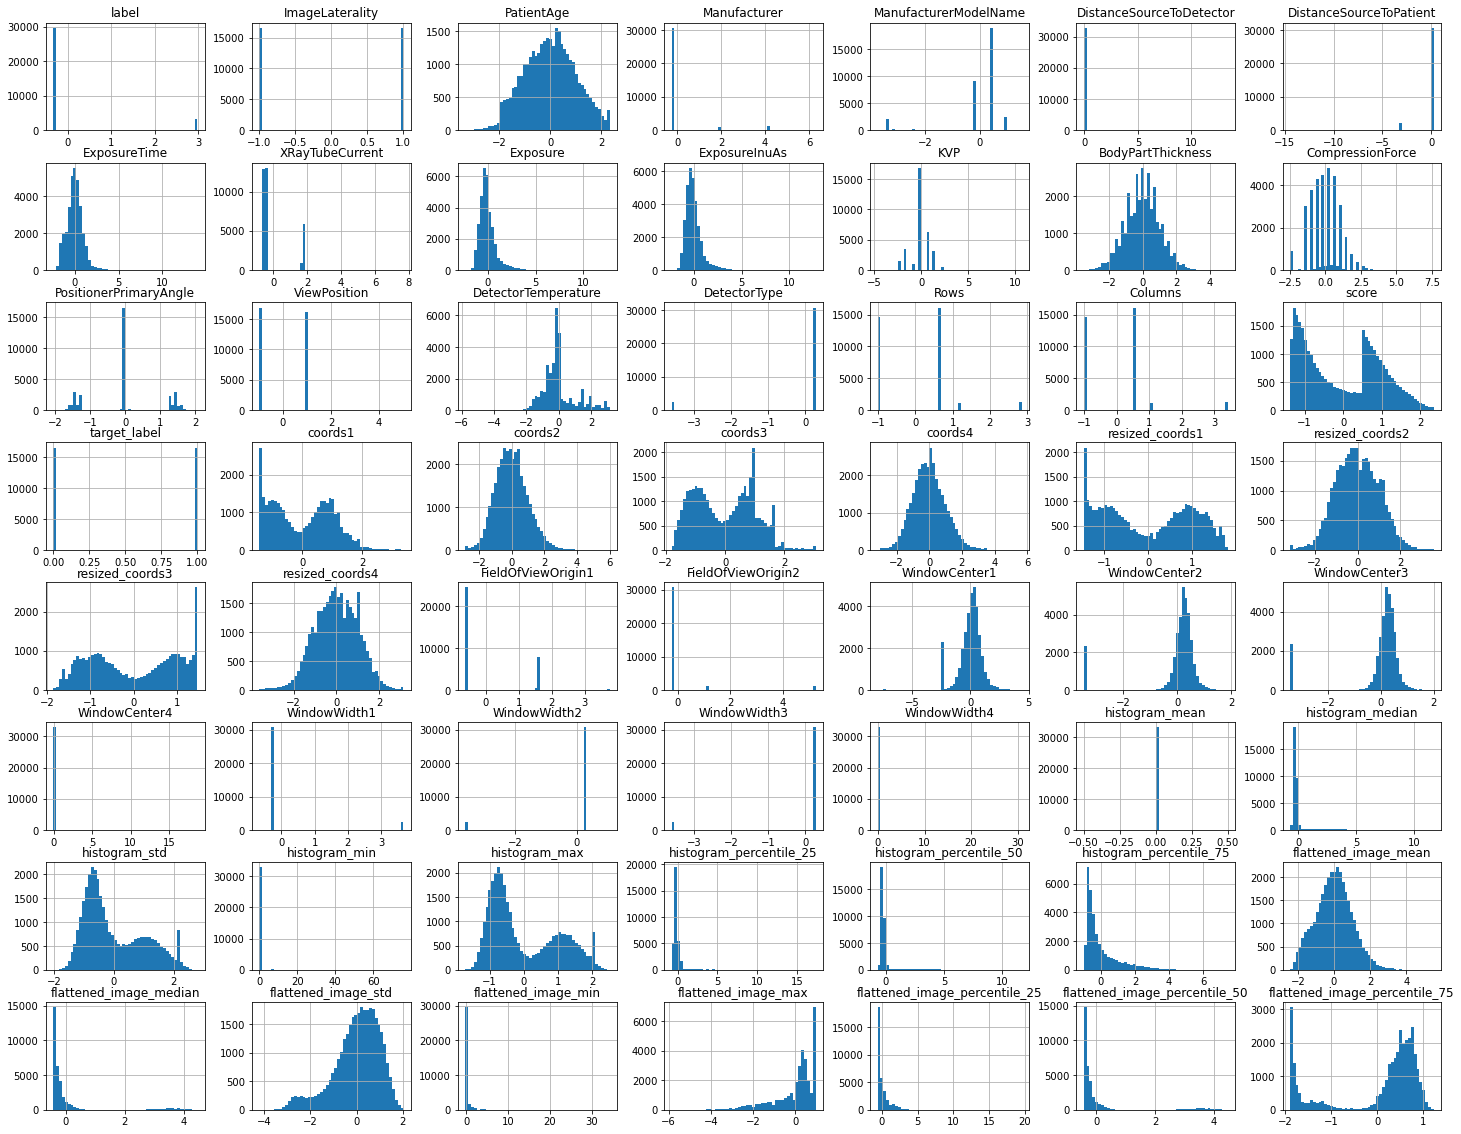

In [20]:
# Descriptive statistics
print(cleaned_df.describe())

# Histograms for feature distribution
cleaned_df.hist(bins=50, figsize=(25,20))
plt.show()


In [ ]:
# Select a subset of features for clarity
# 'label', 'ImageLaterality', 'PatientAge', 'Manufacturer',
#        'ManufacturerModelName', 'DistanceSourceToDetector',
#        'DistanceSourceToPatient', 'ExposureTime', 'XRayTubeCurrent',
#        'Exposure', 'ExposureInuAs', 'KVP', 'BodyPartThickness',
#        'CompressionForce', 'PositionerPrimaryAngle', 'ViewPosition',
#        'DetectorTemperature', 'DetectorType', 'Rows', 'Columns', 'score',
#        'target_label', 'coords1', 'coords2', 'coords3', 'coords4',
#        'resized_coords1', 'resized_coords2', 'resized_coords3',
#        'resized_coords4', 'FieldOfViewOrigin1', 'FieldOfViewOrigin2',
#        'WindowCenter1', 'WindowCenter2', 'WindowCenter3', 'WindowCenter4',
#        'WindowWidth1', 'WindowWidth2', 'WindowWidth3', 'WindowWidth4',
#        'histogram_mean', 'histogram_median', 'histogram_std', 'histogram_min',
#        'histogram_max', 'histogram_percentile_25', 'histogram_percentile_50',
#        'histogram_percentile_75', 'flattened_image_mean',
#        'flattened_image_median', 'flattened_image_std', 'flattened_image_min',
#        'flattened_image_max', 'flattened_image_percentile_25',
#        'flattened_image_percentile_50', 'flattened_image_percentile_75'

subset_of_features = [
    'label', 'ImageLaterality','PatientAge', 'Manufacturer',
    'ManufacturerModelName', 'DistanceSourceToDetector',
    'DistanceSourceToPatient', 'ExposureTime', 'XRayTubeCurrent',
    'Exposure', 'ExposureInuAs', 'KVP', 'BodyPartThickness',
    'CompressionForce', 'PositionerPrimaryAngle', 'ViewPosition',
    'DetectorTemperature', 'DetectorType', 'Rows', 'Columns', 'score',
    'target_label', 'coords1', 'coords2', 'coords3', 'coords4',
    'resized_coords1', 'resized_coords2', 'resized_coords3',
    'resized_coords4', 'FieldOfViewOrigin1', 'FieldOfViewOrigin2',
    'WindowCenter1', 'WindowCenter2', 'WindowCenter3', 'WindowCenter4',
    'WindowWidth1', 'WindowWidth2', 'WindowWidth3', 'WindowWidth4',
    'histogram_mean', 'histogram_median', 'histogram_std', 'histogram_min',
    'histogram_max', 'histogram_percentile_25', 'histogram_percentile_50',
    'histogram_percentile_75', 'flattened_image_mean',
    'flattened_image_median', 'flattened_image_std', 'flattened_image_min',
    'flattened_image_max', 'flattened_image_percentile_25',
    'flattened_image_percentile_50', 'flattened_image_percentile_75'
]

# Plot histograms for the subset of features
cleaned_df[subset_of_features].hist(bins=50, figsize=(25,20))
plt.show()

# Plot density plots for the subset of features
cleaned_df[subset_of_features].plot(kind='density', subplots=True, layout=(7,8), sharex=False, figsize=(15,10))
plt.show()

# Box plots for the subset of features
cleaned_df[subset_of_features].plot(kind='box', subplots=True, layout=(7,8), sharex=False, sharey=False, figsize=(15,10))
plt.show()


In [47]:
corr_matrix = cleaned_df.corr()

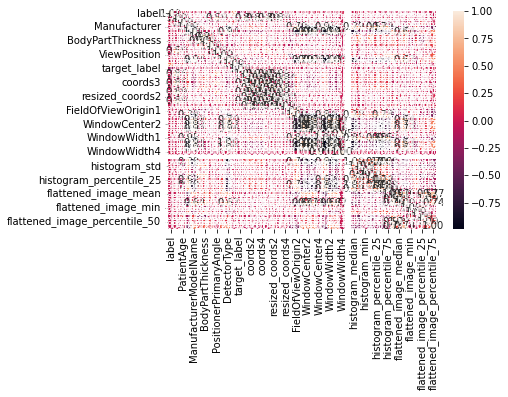

In [49]:
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

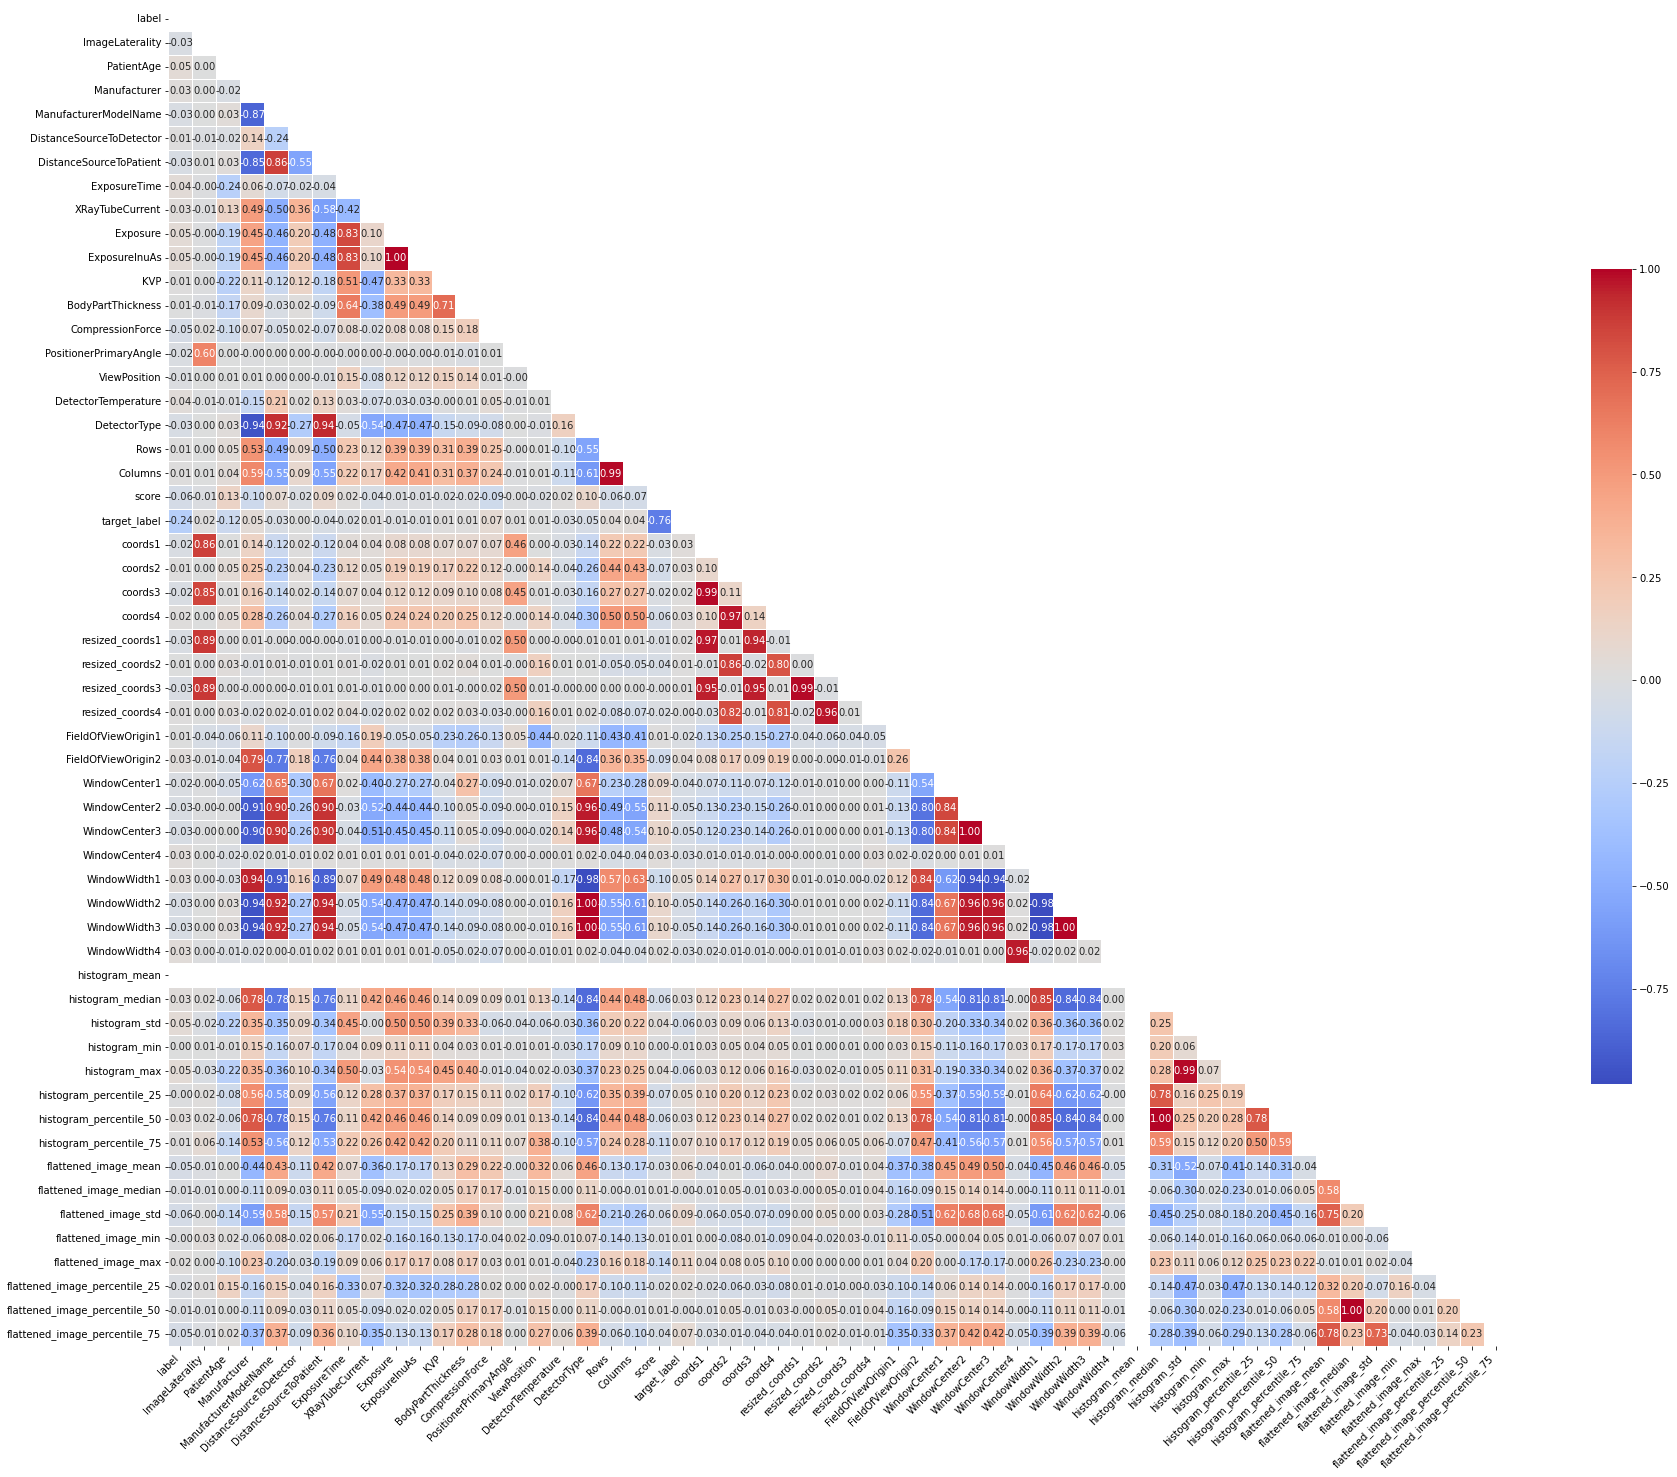

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = cleaned_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(30, 30))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap='coolwarm', square=True, cbar_kws={"shrink": .5},
            linewidths=.5)

# Rotate feature labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()


In [23]:
len(cleaned_df)

161299

In [41]:
cleaned_df.columns

Index(['label', 'ImageLaterality', 'PatientAge', 'Manufacturer',
       'ManufacturerModelName', 'DistanceSourceToDetector',
       'DistanceSourceToPatient', 'ExposureTime', 'XRayTubeCurrent',
       'Exposure', 'ExposureInuAs', 'KVP', 'BodyPartThickness',
       'CompressionForce', 'PositionerPrimaryAngle', 'ViewPosition',
       'DetectorTemperature', 'DetectorType', 'Rows', 'Columns', 'score',
       'target_label', 'coords1', 'coords2', 'coords3', 'coords4',
       'resized_coords1', 'resized_coords2', 'resized_coords3',
       'resized_coords4', 'FieldOfViewOrigin1', 'FieldOfViewOrigin2',
       'WindowCenter1', 'WindowCenter2', 'WindowCenter3', 'WindowCenter4',
       'WindowWidth1', 'WindowWidth2', 'WindowWidth3', 'WindowWidth4',
       'histogram_mean', 'histogram_median', 'histogram_std', 'histogram_min',
       'histogram_max', 'histogram_percentile_25', 'histogram_percentile_50',
       'histogram_percentile_75', 'flattened_image_mean',
       'flattened_image_median', 'fla

In [35]:
csv_path = "/home/ryan.zurrin001/Projects/omama/_EXPERIMENTS/CS438/labels/features_balanced_scaled.csv"

In [36]:
cleaned_df.to_csv(csv_path, index=False)

In [43]:
# Remove 'label' and 'score' columns in place
cleaned_df.drop(columns=['label', 'score', 'coords1', 'coords2', 'coords3', 'coords4', 'resized_coords1', 'resized_coords2', 'resized_coords3',
       'resized_coords4' ], inplace=True)


In [44]:
unique_values = cleaned_df.nunique()

print("Number of unique values per column:")
print(unique_values)

Number of unique values per column:
ImageLaterality                      2
PatientAge                         723
Manufacturer                         4
ManufacturerModelName               24
DistanceSourceToDetector             2
DistanceSourceToPatient             55
ExposureTime                      1812
XRayTubeCurrent                     36
Exposure                           226
ExposureInuAs                     1393
KVP                                 19
BodyPartThickness                  112
CompressionForce                   280
PositionerPrimaryAngle             145
ViewPosition                         3
DetectorTemperature                479
DetectorType                         2
Rows                                 5
Columns                              6
target_label                         2
FieldOfViewOrigin1                   7
FieldOfViewOrigin2                  31
WindowCenter1                      362
WindowCenter2                      357
WindowCenter3               

In [45]:
# Assuming `df` is your DataFrame and 'target_label' is your column of interest
count_of_values = cleaned_df['target_label'].value_counts()

# This will print the count of each unique value in the 'target_label' column
print(count_of_values)

0    16532
1    16532
Name: target_label, dtype: int64


In [46]:
# Define your features and target variable
X = cleaned_df.drop('target_label', axis=1)  # all columns except the label
y = cleaned_df['target_label']  # the target variable

# Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [48]:
X

,ImageLaterality,PatientAge,Manufacturer,ManufacturerModelName,DistanceSourceToDetector,DistanceSourceToPatient,ExposureTime,XRayTubeCurrent,Exposure,ExposureInuAs,...,histogram_percentile_50,histogram_percentile_75,flattened_image_mean,flattened_image_median,flattened_image_std,flattened_image_min,flattened_image_max,flattened_image_percentile_25,flattened_image_percentile_50,flattened_image_percentile_75
0,1.003029,-1.019133,-0.260959,0.400808,-0.074602,0.259023,0.543056,-0.521233,0.263766,0.268683,...,-0.242959,0.338853,-0.387185,-0.382759,0.312392,-0.236513,0.307439,-0.493420,-0.382759,0.456948
1,-0.996980,-0.596168,-0.260959,0.400808,-0.074602,0.259023,-0.542750,-0.521233,-0.756399,-0.738037,...,-0.242959,-0.285588,-1.094938,-0.113591,-0.950779,-0.236513,0.527894,0.685027,-0.113591,-1.699585
2,1.003029,0.464828,4.106723,-3.352535,-0.074602,-3.055222,-0.480704,1.778631,0.588364,0.607349,...,0.869539,2.860182,-1.678530,-0.431699,-2.587036,-0.236513,0.968803,-0.600552,-0.431699,-1.197379
3,1.003029,0.156566,-0.260959,0.400808,-0.074602,0.259023,-0.586182,-0.521233,-0.756399,-0.779790,...,-0.322423,-0.556572,-1.213774,-0.089121,-2.003034,0.672163,-5.056957,0.792158,-0.089121,-1.684815
4,-0.996980,-0.359595,-0.260959,0.963809,-0.074602,0.259023,0.046687,-0.580204,-0.292687,-0.274111,...,-0.084030,0.315289,0.377671,-0.431699,0.619316,-0.236513,0.013499,-0.600552,-0.431699,0.530802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33059,1.003029,-0.452790,-0.260959,-0.162194,-0.074602,0.259023,0.037381,-0.462263,-0.199945,-0.199883,...,-0.322423,-0.155987,-1.166774,-0.333820,-0.484424,-0.236513,0.601379,-0.279157,-0.333820,-1.817752
33060,1.003029,-0.459959,-0.260959,0.400808,-0.074602,0.259023,-0.210804,-0.462263,-0.431801,-0.431846,...,-0.242959,-0.368061,-0.095028,-0.284880,0.528509,-0.236513,0.013499,-0.172026,-0.284880,0.648968
33061,1.003029,-0.703702,-0.260959,-0.162194,-0.074602,0.259023,0.239030,-0.521233,-0.014461,-0.014312,...,-0.322423,-0.745083,-0.367854,-0.333820,0.047974,-0.236513,-2.044077,-0.386289,-0.333820,0.442177
33062,-0.996980,0.493504,-0.260959,-0.162194,-0.074602,0.259023,-0.226315,-0.462263,-0.431801,-0.445764,...,-0.322423,-0.686173,-0.973568,-0.382759,-0.736164,-0.236513,0.601379,-0.493420,-0.382759,0.087678


In [49]:
y

0        1
1        1
2        1
3        0
4        0
        ..
33059    1
33060    0
33061    0
33062    0
33063    0
Name: target_label, Length: 33064, dtype: int64

In [50]:
X_train

,ImageLaterality,PatientAge,Manufacturer,ManufacturerModelName,DistanceSourceToDetector,DistanceSourceToPatient,ExposureTime,XRayTubeCurrent,Exposure,ExposureInuAs,...,histogram_percentile_50,histogram_percentile_75,flattened_image_mean,flattened_image_median,flattened_image_std,flattened_image_min,flattened_image_max,flattened_image_percentile_25,flattened_image_percentile_50,flattened_image_percentile_75
18638,-0.996980,-0.115852,-0.260959,0.963809,-0.074602,0.259023,1.237971,-0.462263,0.912961,0.913540,...,-0.163495,0.020742,-1.123390,-0.431699,-0.159752,-0.236513,0.968803,-0.600552,-0.431699,-1.876835
2448,1.003029,-0.123021,-0.260959,0.400808,-0.074602,0.259023,0.440680,-0.462263,0.171024,0.175851,...,-0.242959,-0.662609,-0.373314,-0.431699,0.116718,-0.236513,0.454409,-0.600552,-0.431699,0.353552
9033,-0.996980,0.937976,-0.260959,-0.162194,-0.074602,0.259023,0.791240,-0.462263,0.495621,0.500646,...,-0.084030,0.327071,-0.197711,-0.431699,-0.119896,-0.236513,0.968803,-0.600552,-0.431699,0.250157
32087,-0.996980,-1.033471,-0.260959,-0.162194,-0.074602,0.259023,-0.111530,-0.462263,-0.339059,-0.339061,...,-0.322423,-0.686173,-0.056124,-0.089121,-0.230638,-0.236513,0.454409,0.792158,-0.089121,0.486489
22362,1.003029,-0.782559,-0.260959,0.963809,-0.074602,0.259023,-0.700967,-0.521233,-0.895512,-0.886494,...,-0.004566,-0.179551,3.311085,4.193104,0.468076,-0.236513,0.527894,2.399132,4.193104,1.003466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,-0.996980,-0.804066,-0.260959,0.963809,-0.074602,0.259023,0.021869,-0.521233,-0.199945,-0.213801,...,-0.322423,-0.756865,-0.544687,-0.138061,-0.356211,3.398190,-0.206955,0.577895,-0.138061,-1.699585
6265,-0.996980,-0.617675,-0.260959,0.400808,-0.074602,0.259023,0.006358,-0.521233,-0.246316,-0.227718,...,-0.242959,0.480236,0.702853,-0.333820,0.967802,-0.236513,0.233954,-0.279157,-0.333820,0.722822
11284,1.003029,0.013188,-0.260959,0.400808,-0.074602,0.259023,0.242132,-0.521233,-0.014461,-0.009673,...,-0.401887,-0.851120,-0.531048,-0.260410,0.364819,-0.236513,0.527894,0.042237,-0.260410,-1.788210
860,1.003029,0.500673,1.922882,-3.164868,13.404387,-7.363741,0.558567,1.778631,2.628693,2.616149,...,0.869539,1.434571,-1.925619,-0.431699,-2.748465,-0.236513,0.968803,-0.600552,-0.431699,-1.551878


In [51]:
y_train

18638    1
2448     1
9033     0
32087    1
22362    0
        ..
16850    1
6265     1
11284    1
860      1
15795    1
Name: target_label, Length: 19838, dtype: int64

In [52]:
X_test

,ImageLaterality,PatientAge,Manufacturer,ManufacturerModelName,DistanceSourceToDetector,DistanceSourceToPatient,ExposureTime,XRayTubeCurrent,Exposure,ExposureInuAs,...,histogram_percentile_50,histogram_percentile_75,flattened_image_mean,flattened_image_median,flattened_image_std,flattened_image_min,flattened_image_max,flattened_image_percentile_25,flattened_image_percentile_50,flattened_image_percentile_75
19530,-0.996980,-0.667857,-0.260959,0.400808,-0.074602,0.259023,-0.511727,-0.521233,-0.710028,-0.710202,...,-0.481351,-0.686173,-1.259396,-0.358289,-0.034062,-0.236513,0.454409,-0.493420,-0.358289,-1.847293
10276,1.003029,-0.287906,-0.260959,0.400808,-0.074602,0.259023,-0.493113,-0.462263,-0.710028,-0.696284,...,-0.401887,-0.768646,-0.118321,0.082168,-0.748485,-0.236513,0.821833,1.542079,0.082168,0.383094
4271,-0.996980,0.464828,-0.260959,-0.162194,-0.074602,0.259023,-0.694763,-0.521233,-0.895512,-0.877215,...,-0.163495,0.279944,0.857115,0.302397,-0.152312,-0.236513,0.454409,2.399132,0.302397,0.663739
27627,1.003029,0.027526,-0.260959,0.400808,-0.074602,0.259023,1.067345,-0.462263,0.773848,0.755805,...,-0.401887,-0.851120,-0.768867,-0.431699,-0.066183,-0.236513,-0.059985,-0.600552,-0.431699,0.368323
7339,-0.996980,0.780260,-0.260959,-0.162194,-0.074602,0.259023,0.319690,-0.521233,0.078281,0.059916,...,-0.242959,0.774784,1.091975,-0.235940,1.172922,-0.236513,0.307439,0.149369,-0.235940,0.870529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10953,1.003029,0.758753,-0.260959,-2.414199,-0.074602,0.259023,-0.393839,-0.462263,-0.617285,-0.603499,...,-0.322423,-0.721519,0.728140,1.428010,0.160547,-0.236513,0.968803,-0.600552,1.428010,0.338782
23304,-0.996980,0.464828,-0.260959,0.400808,-0.074602,0.259023,-0.145655,-0.521233,-0.385430,-0.371535,...,-0.322423,-0.674391,-0.207211,-0.382759,0.475979,-0.236513,-0.133470,-0.493420,-0.382759,0.634197
4907,1.003029,-1.320227,-0.260959,0.400808,-0.074602,0.259023,0.124245,-0.580204,-0.199945,-0.204522,...,-0.401887,-0.615482,-1.402518,-0.431699,-0.307988,-0.236513,0.307439,-0.600552,-0.431699,-1.906376
5570,-0.996980,0.679895,-0.260959,0.400808,-0.074602,0.259023,0.037381,-0.521233,-0.199945,-0.199883,...,-0.401887,-0.615482,-0.237811,-0.211470,-0.255753,-0.236513,-2.044077,0.256501,-0.211470,0.353552


In [53]:
y_test

19530    1
10276    0
4271     0
27627    1
7339     1
        ..
10953    0
23304    1
4907     1
5570     0
22589    0
Name: target_label, Length: 6613, dtype: int64

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
X_train_scaled

array([[-0.2125764 , -1.00218001,  0.69284528, ..., -0.19911959,
        -0.33200145,  0.73888691],
       [-0.2125764 , -1.00218001,  0.87877175, ..., -0.0888487 ,
        -0.28173996, -1.85900187],
       [-0.2125764 ,  0.99782473,  0.14936789, ...,  0.79331845,
        -0.10582475,  0.38260502],
       ...,
       [-0.2125764 ,  0.99782473,  0.82871462, ..., -0.0888487 ,
        -0.28173996,  0.5310558 ],
       [-0.2125764 ,  0.99782473, -0.65869718, ..., -0.64020317,
         4.16640197,  0.94671801],
       [-0.2125764 , -1.00218001, -0.83747264, ..., -0.64020317,
        -0.43252443,  0.75373198]])

In [79]:
X_test_scaled

array([[-0.2125764 ,  0.99782473, -0.49422376, ..., -0.64020317,
        -0.43252443,  0.69435167],
       [-0.2125764 , -1.00218001,  1.12190638, ...,  0.79331845,
        -0.080694  ,  0.23415423],
       [-0.2125764 , -1.00218001,  0.40680454, ...,  0.46250577,
        -0.15608624,  0.51621072],
       ...,
       [-0.2125764 ,  0.99782473,  0.54267389, ..., -0.0888487 ,
        -0.28173996,  0.69435167],
       [-0.2125764 , -1.00218001, -1.57402752, ..., -0.30939049,
        -0.30687071,  0.45683041],
       [-0.2125764 ,  0.99782473,  0.14936789, ..., -0.64020317,
        -0.43252443, -1.62148061]])

In [54]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(X_train, y_train)

# Validate the model
y_val_pred = log_reg.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      3243
           1       0.63      0.62      0.62      3370

    accuracy                           0.62      6613
   macro avg       0.62      0.62      0.62      6613
weighted avg       0.62      0.62      0.62      6613



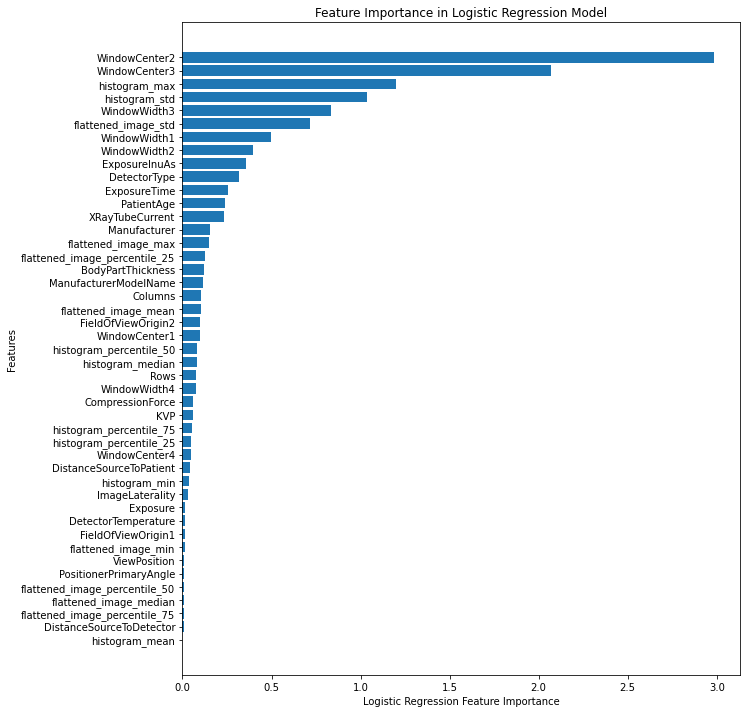

In [55]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Assuming log_reg is your trained Logistic Regression model
feature_importance = abs(log_reg.coef_[0])
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 12))  # You can adjust the dimensions (width, height) as needed
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel('Logistic Regression Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Logistic Regression Model')
plt.show()

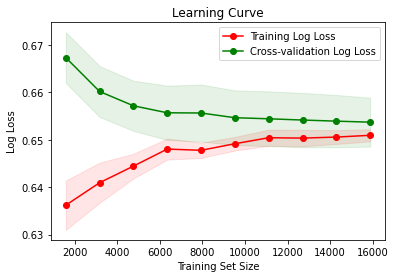

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Define the range of training sizes and the number of folds for cross-validation
train_sizes = np.linspace(0.1, 1.0, 10)
n_jobs = -1 # Use all available cores

train_sizes, train_scores, validation_scores = learning_curve(
    log_reg, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='neg_log_loss', n_jobs=n_jobs)

# Calculate mean and standard deviation for training set scores
train_mean = -np.mean(train_scores, axis=1)  # Note the negative sign
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
validation_mean = -np.mean(validation_scores, axis=1)  # Note the negative sign
validation_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, validation_mean - validation_std,
                 validation_mean + validation_std, color="g", alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Log Loss")
plt.plot(train_sizes, validation_mean, 'o-', color="g", label="Cross-validation Log Loss")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss")
plt.legend(loc="best")
plt.show()

In [61]:
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = dict(enumerate(class_weights))

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [62]:
# Validate the model
y_val = model.predict(X_val)
print(classification_report(y_val, y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3212
           1       1.00      1.00      1.00      3401

    accuracy                           1.00      6613
   macro avg       1.00      1.00      1.00      6613
weighted avg       1.00      1.00      1.00      6613



In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  18.6s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s


[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  18.7s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  18.6s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  36.9s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  36.8s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  37.7s
[CV] max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  19.2s
[CV] max_depth=None, min_sampl

[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  18.3s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  19.1s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  36.5s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  36.8s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  37.2s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  18.6s
[CV] max_depth=20, min_samples_leaf=1, min_samples_s

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 30.9min finished


Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [19]:
# from sklearn.ensemble import RandomForestClassifier

# # Calculate class weights for binary classification
# weight_for_0 = (1 / count_of_values[0]) * (len(cleaned_df) / 2.0)
# weight_for_1 = (1 / count_of_values[1]) * (len(cleaned_df) / 2.0)

# class_weights = {0: weight_for_0, 1: weight_for_1}

# model2 = RandomForestClassifier(class_weight=class_weights, random_state=42)
# model2.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 4.8783873699491895,
                                     1: 0.5570986481725807},
                       random_state=42)

In [20]:
# # Predict on the test data
# y_pred = model2.predict(X_test_scaled)

# # Evaluate the model
# print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3307
           1       1.00      1.00      1.00     28953

    accuracy                           1.00     32260
   macro avg       1.00      1.00      1.00     32260
weighted avg       1.00      1.00      1.00     32260

[[ 3305     2]
 [    0 28953]]


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Calculate class weights
# class_weights = {0: 1,
#                  1: (len(y_train) - sum(y_train)) / sum(y_train)}

# model = RandomForestClassifier(class_weight=class_weights, random_state=42)
# model.fit(X_train_scaled, y_train)


In [63]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.63      0.62      0.62      3293
           1       0.63      0.64      0.63      3320

    accuracy                           0.63      6613
   macro avg       0.63      0.63      0.63      6613
weighted avg       0.63      0.63      0.63      6613

[[2032 1261]
 [1195 2125]]


In [70]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Initialize alternative models
# svm_model = SVC(probability=True)
neural_net = MLPClassifier(max_iter=1000)

# Fit alternative models
# Note: These models have their own hyperparameters that you can tune
# svm_model.fit(X_train, y_train)
neural_net.fit(X_train, y_train)

# Validate alternative models
# Evaluate their performance and compare with the logistic regression model

MLPClassifier(max_iter=1000)

In [71]:
# Predict on the test data
y_pred_nn = neural_net.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_nn))
print(confusion_matrix(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      3293
           1       0.60      0.60      0.60      3320

    accuracy                           0.60      6613
   macro avg       0.60      0.60      0.60      6613
weighted avg       0.60      0.60      0.60      6613

[[1961 1332]
 [1315 2005]]


In [72]:
from sklearn.metrics import classification_report

# Predict on the validation set
y_pred_neural_net = neural_net.predict(X_val)

# Print classification report
print("Neural Network Classification Report:")
print(classification_report(y_val, y_pred_neural_net))


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      3212
           1       0.73      0.72      0.72      3401

    accuracy                           0.72      6613
   macro avg       0.72      0.72      0.72      6613
weighted avg       0.72      0.72      0.72      6613



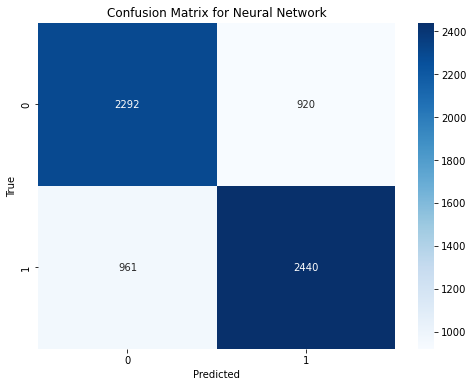

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm_neural_net = confusion_matrix(y_val, y_pred_neural_net)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_neural_net, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Neural Network')
plt.show()


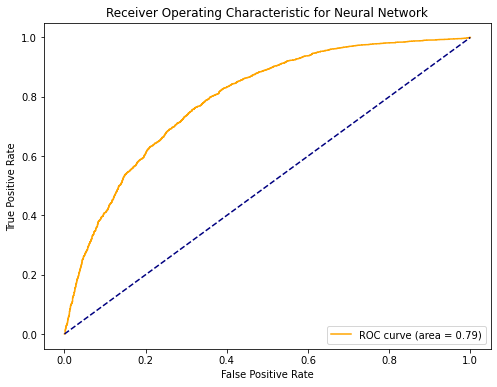

In [74]:
from sklearn.metrics import roc_curve, auc

# Get probability estimates for the positive class
y_prob_neural_net = neural_net.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr_neural_net, tpr_neural_net, _ = roc_curve(y_val, y_prob_neural_net)
roc_auc_neural_net = auc(fpr_neural_net, tpr_neural_net)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_neural_net, tpr_neural_net, color='orange', label=f'ROC curve (area = {roc_auc_neural_net:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Neural Network')
plt.legend(loc='lower right')
plt.show()


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

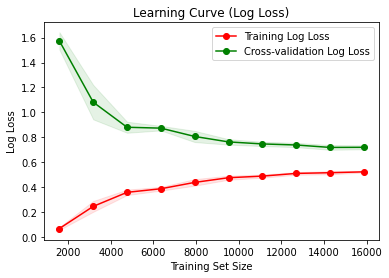

In [75]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, log_loss

# Assuming neural_net is your MLPClassifier model

# Create a scorer from the log_loss function
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

train_sizes, train_scores, validation_scores = learning_curve(
    neural_net, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring=log_loss_scorer, n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = -np.mean(train_scores, axis=1)  # Note the negative sign
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
validation_mean = -np.mean(validation_scores, axis=1)  # Note the negative sign
validation_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="g", alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Log Loss")
plt.plot(train_sizes, validation_mean, 'o-', color="g", label="Cross-validation Log Loss")

plt.title("Learning Curve (Log Loss)")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss")
plt.legend(loc="best")
plt.show()


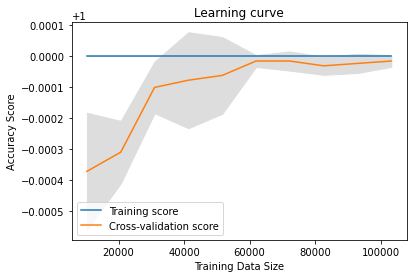

In [26]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=X_train_scaled, y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1, scoring='accuracy'
)

# Calculate mean and standard deviation of train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')

plt.title('Learning curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()
